In [1]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from keras.models import model_from_json
import matplotlib.pyplot as plt                        
%matplotlib inline 
image.

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
# import the necessary packages
from collections import deque
import numpy as np
import argparse
import imutils
import cv2
import urllib
import os
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from keras.models import model_from_json
import matplotlib.pyplot as plt 


# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-v", "--video",
    help="path to the (optional) video file")
ap.add_argument("-b", "--buffer", type=int, default=64,
    help="max buffer size")
args = vars(ap.parse_args())

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/Users/panda/Desktop/imageclassifier/data/train'
validation_data_dir = '/Users/panda/Desktop/imageclassifier/data/validation/'
test_data_dir = '/Users/panda/Desktop/imageclassifier/data/test/'

nb_epoch = 50
nb_train_samples = 331
nb_validation_samples = 61

# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255, # scale images
                            zoom_range=0.01, # randomly zoom into images 1% of images
                            width_shift_range=0.1,# randomly shift images horizontally (10% of total width)
                            height_shift_range=0.1,# randomly shift images vertically (10% of total height)
                            horizontal_flip=True)# randomly flip images horizontally


 
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=25,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=25,
        class_mode='binary')
    
# Load the Keras Model for Router Detection
print('Loading the Model from disk.')
json_file = open('/Users/panda/Desktop/imageclassifier/models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
print('Loading model weighta')
loaded_model.load_weights("/Users/panda/Desktop/imageclassifier/models/basic_cnn_30_epochs.h5")
print("Successfully loaded the model from disk.")

print('Model compilation started')
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print('Model compilation completed successfully')

loss,accuracy=loaded_model.evaluate_generator(validation_generator, nb_validation_samples)
print('###### Model Evaluation Metrics ######')
print('Loss: ',loss)
print('Accuracy: ',accuracy)
    
# define the lower and upper boundaries of the colors in the HSV color space
lower = {'Red':(166, 84, 141), 'Green':(33,80,40),'orange':(0, 41, 75)} 
#assign new item lower['blue'] = (93, 10, 0)
upper = {'Red':(186,255,255), 'Green':(102,255,255),'orange':(20,255,255)}

# define standard colors for circle around the object
colors = {'Red':(0,0,255), 'Green':(0,255,0),'orange':(0,140,255)}

#pts = deque(maxlen=args["buffer"])
 
# if a video path was not supplied, grab the reference
# to the webcam
if not args.get("video", False):
    camera = cv2.VideoCapture(0)
    
 
# otherwise, grab a reference to the video file
else:
    camera = cv2.VideoCapture(args["video"])
# keep looping
while True:
    # grab the current frame
    (grabbed, frame) = camera.read()
    # if we are viewing a video and we did not grab a frame,
    # then we have reached the end of the video
    if args.get("video") and not grabbed:
        break

    #frame = cv2.imread('/Users/panda/Pictures/router.png')
 
    # resize the frame, blur it, and convert it to the HSV
    # color space
    frame = imutils.resize(frame, width=600)

    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    #for each color in dictionary check object in frame
    for key, value in upper.items():
        # construct a mask for the color from dictionary`1, then perform
        # a series of dilations and erosions to remove any small
        # blobs left in the mask
        kernel = np.ones((9,9),np.uint8)
        mask = cv2.inRange(hsv, lower[key], upper[key])
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
                
        # find contours in the mask and initialize the current
        # (x, y) center of the ball
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)[-2]
        center = None
        
        # only proceed if at least one contour was found
        if len(cnts) > 0:
            # find the largest contour in the mask, then use
            # it to compute the minimum enclosing circle and
            # centroid
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        
            # only proceed if the radius meets a minimum size. Correct this value for your obect's size
            if radius > 0.001:
                # draw the circle and centroid on the frame,
                # then update the list of tracked points
                cv2.circle(frame, (int(x), int(y)), int(radius), colors[key], 2)
                cv2.putText(frame,key + " Light", (int(x-radius),int(y-radius)), cv2.FONT_HERSHEY_SIMPLEX, 0.6,colors[key],2)
                if(key=='Green'):
                    print('Seems Everythng Okay')
                elif(key=='Red'):
                    print('Seems there is some problem with your router')

     
    # show the frame to our screen
    cv2.imshow("Frame", frame)
    
    key = cv2.waitKey(1) & 0xFF
    # if the 'q' key is pressed, stop the loop
    if key == ord("q"):
        break
 
#cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()

### 1. Load the Dataset

In [2]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/Users/panda/Desktop/imageclassifier/data/train'
validation_data_dir = '/Users/panda/Desktop/imageclassifier/data/validation/'
test_data_dir = '/Users/panda/Desktop/imageclassifier/data/test/'

### 2. Create Data Generator

#### Handling Invariant Issue with Data Augmentation
* Scale Invariant
* Translation Invariant
* Rotational Invariant


In [3]:
# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255, # scale images
                            zoom_range=0.01, # randomly zoom into images 1% of images
                            width_shift_range=0.1,# randomly shift images horizontally (10% of total width)
                            height_shift_range=0.1,# randomly shift images vertically (10% of total height)
                            horizontal_flip=True)# randomly flip images horizontally


# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=25,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=25,
        class_mode='binary')


Found 331 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


### 3. Define Model Architecture

In [4]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))

model.add(Activation('sigmoid'))

model.summary()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(150, 150,...)`
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

### 4. Compile the Model

In [5]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

### 5. Configure Parameters

In [6]:
nb_epoch = 50
nb_train_samples = 331
nb_validation_samples = 61

### 6. Train the Model

In [7]:
model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=13, epochs=50, validation_steps=61)`
  


Epoch 1/50
13/13 [==============================] - 84s - loss: 0.8538 - acc: 0.6492 - val_loss: 0.6982 - val_acc: 0.5092
Epoch 2/50
13/13 [==============================] - 77s - loss: 0.5622 - acc: 0.6916 - val_loss: 0.7222 - val_acc: 0.5288
Epoch 3/50
13/13 [==============================] - 77s - loss: 0.4340 - acc: 0.7839 - val_loss: 0.5354 - val_acc: 0.6514
Epoch 4/50
13/13 [==============================] - 70s - loss: 0.3304 - acc: 0.8519 - val_loss: 0.3780 - val_acc: 0.8514
Epoch 5/50
13/13 [==============================] - 70s - loss: 0.3354 - acc: 0.9042 - val_loss: 0.3767 - val_acc: 0.8099
Epoch 6/50
13/13 [==============================] - 68s - loss: 0.2340 - acc: 0.9166 - val_loss: 0.6209 - val_acc: 0.7470
Epoch 7/50
13/13 [==============================] - 73s - loss: 0.2045 - acc: 0.9320 - val_loss: 0.5627 - val_acc: 0.7920
Epoch 8/50
13/13 [==============================] - 79s - loss: 0.5534 - acc: 0.8490 - val_loss: 0.3317 - val_acc: 0.8652
Epoch 9/50
13/13 [======

### 7. Save the Model

In [8]:
# serialize model to JSON
print('serializing model to JSON')

model_json = model.to_json()
#with open("/Users/panda/Desktop/imageclassifier/models/basic_model.json", "w") as json_file:
with open("/Users/panda/Desktop/imageclassifier/models/augmented_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights('/Users/panda/Desktop/imageclassifier/models/augmented_cnn_50_epochs.h5')

print("Saved model to disk")

serializing model to JSON
Saved model to disk


### 8. Evaluate Model

In [9]:
loss,accuracy=model.evaluate_generator(validation_generator, nb_validation_samples)
print('###### Model Evaluation Metrics ######')
print('Loss: ',loss)
print('Accuracy: ',accuracy)

###### Model Evaluation Metrics ######
Loss:  0.4252189888809522
Accuracy:  0.9044176691985992


### 9. Load the model

In [20]:
# load json and create model
#json_file = open('/Users/panda/Desktop/imageclassifier/models/model.json', 'r')
json_file = open('/Users/panda/Desktop/imageclassifier/models/augmented_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("/Users/panda/Desktop/imageclassifier/models/basic_cnn_30_epochs.h5")
loaded_model.load_weights("/Users/panda/Desktop/imageclassifier/models/augmented_cnn_50_epochs.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

loss,accuracy=loaded_model.evaluate_generator(validation_generator, nb_validation_samples)

print('###### Model Evaluation Metrics ######')
print('Loss: ',loss)
print('Accuracy: ',accuracy)

Loaded model from disk
###### Model Evaluation Metrics ######
Loss:  0.46164260089706105
Accuracy:  0.9000812346232219


In [11]:
train_generator.class_indices

{'gen3vz': 0, 'other': 1}

Classes:  {'gen3vz': 0, 'other': 1}


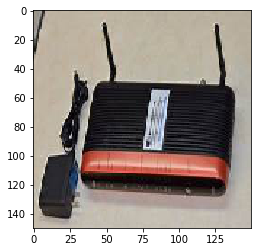

The object in the picture is  gen3vz


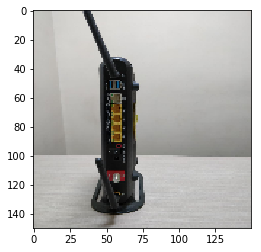

The object in the picture is  other


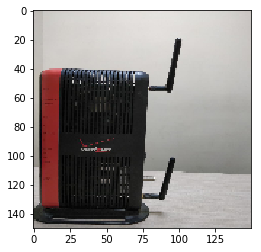

The object in the picture is  gen3vz


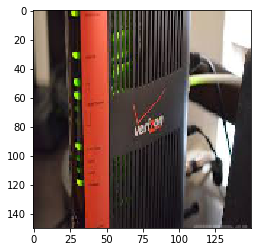

The object in the picture is  other


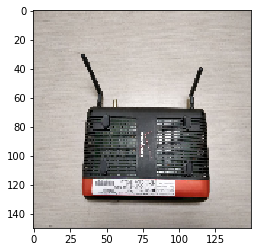

The object in the picture is  other


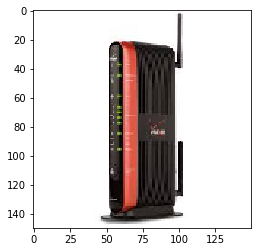

The object in the picture is  other


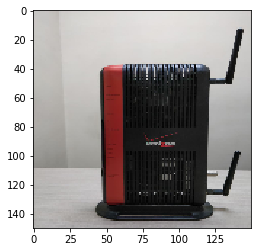

The object in the picture is  other


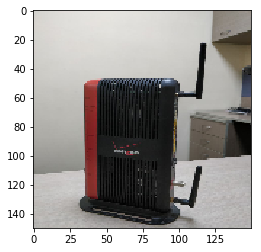

The object in the picture is  gen3vz


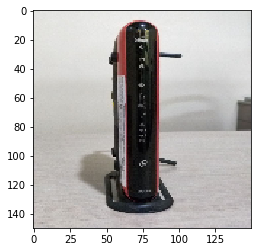

The object in the picture is  other


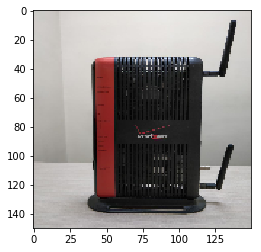

The object in the picture is  gen3vz


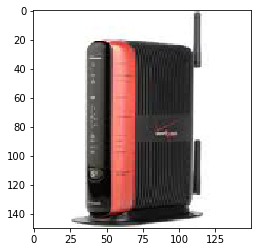

The object in the picture is  other


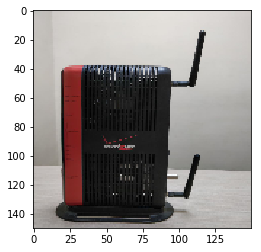

The object in the picture is  gen3vz


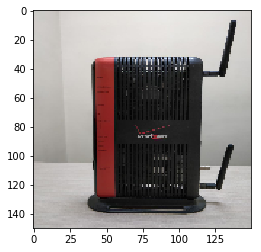

The object in the picture is  gen3vz


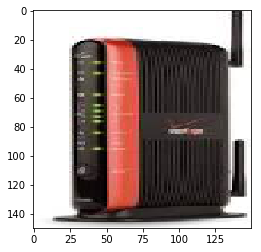

The object in the picture is  other


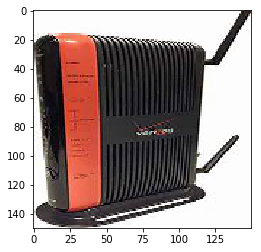

The object in the picture is  other


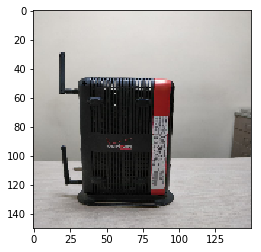

The object in the picture is  other


In [21]:
print('Classes: ',train_generator.class_indices)

PATH_TO_TEST_IMAGES_DIR = '/Users/panda/Desktop/imageclassifier/data/test'
#PATH_TO_TEST_IMAGES_DIR = '/Users/panda/models-master/research/object_detection/test_images/'

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 17) ]

for image_path in TEST_IMAGE_PATHS:
    test_image = image.load_img(image_path,
                            target_size = (150, 150))
    plt.imshow(test_image)
    plt.show()
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = loaded_model.predict(test_image)
    if result[0][0] == 1:
        prediction = 'other'
    else:
        prediction = 'gen3vz'
    print('The object in the picture is ',prediction)
    

In [24]:
import cv2
cap = cv2.VideoCapture(1)
while True:
    ret, image_np = cap.read()
    plt.figure(figsize=(300,300))
    plt.imshow(image_np)
    plt.show()
    cv2.imshow('object detection', cv2.resize(image_np, (800,600)))
    if cv2.waitKey(25) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

TypeError: Image data can not convert to float